# Example 3: Simulating the Earliest Possible Sowing Date for Millet in Niger across Multiple Years

This notebook focuses on determining the earliest possible sowing date for millet in Niger for the period between 1995 and 2020.

The approach consists of conducting yearly simulations with SARRA-Py, using only water balance computations. This is achieved using the `run_waterbalance_model` function, which bypasses all plant-related processes to only compute daily water balance. The detection of sowing date thus solely relies on the first date at which the surface soil water content reaches a defined threshold. Since this approach does not evaluate any plant processes, including plantlet survival during the emergence phase, it ignores potential false starts related to death of the plantlet caused by a early water stress, and might lead to an underestimation of the Day of Year (DOY) value for sowing date. Thus, this approach computes the earliest possible sowing date (EPSD), rather than the earliest successful sowing date (ESSD).

As plant-related processes are not taken into consideration, phenology computations are not performed in this notebook. Therefore, the `DateSemis` parameter from the `itk` simulation parameters file (used to initialize the `sowing_date` variable, which sets a hard date threshold before which sowing is traditionally not practiced by farmers) is not utilized.

The computation is performed as follows : for each year within the specified period, weather, rainfall and simulation parameters are loaded, datasets are prepared, and the simulation is executed. Every simulation starts on January 1st and continues for 220 days, hopefully providing an accurate assessment of the surface soil water content dynamics up to the sowing season, which usually begins in June. At the end of each run, surface soil water content - through the `surface_tank_stock` variable - is screened and the first date for which the threshold is passed marks the EPSD. 

**Note:** The `load_iSDA_soil_data_alternate` method is employed in this notebook, meaning that it uses soil properties maps instead of soil texture map to derive the storage capacity of soil. While this approach is conceptually more appealing, its impact hasn't been properly evaluated yet.

## Imports

In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import io
import xarray as xr
from sarra_py import *
import time
import geopandas as gpd

## Simulation parameters

In [2]:
# weather and rainfall data path
rainfall_data_paths = {
                        "CHIRPS" : "/mnt/d/climate_database/CHIRPS_v2.0_Africa_niger/",
                        "TAMSAT" : "/mnt/d/climate_database/TAMSAT_v3.1_niger_rfe_filled_1983_2021_DL20230614/"
                        
                      }
climate_data_path = "/mnt/d/climate_database/AgERA5_niger_1981_2021_DL20230615/"

# parameter files
file_paramVariete = "millet_variety.yaml"
file_paramITK = "millet_niger_2017.yaml"
file_paramTypeSol = "USA_iowa_V42.yaml"

# simulation parameters
year_start = 1981
year_end = 1989
duration = 220 # days
dataset = "CHIRPS"
water_thresholds = {
                    "TAMSAT":10,
                    "CHIRPS":9
                    } # mm
water_threshold = water_thresholds[dataset]

## Running the simulations

100%|██████████| 220/220 [02:30<00:00,  1.46it/s]


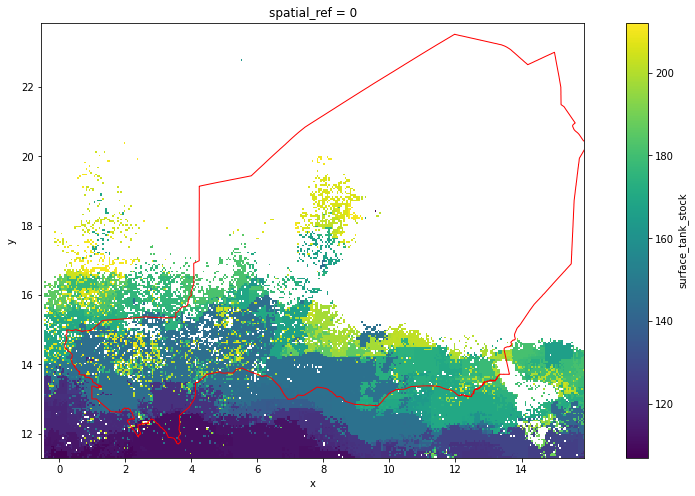

100%|██████████| 220/220 [01:50<00:00,  2.00it/s]


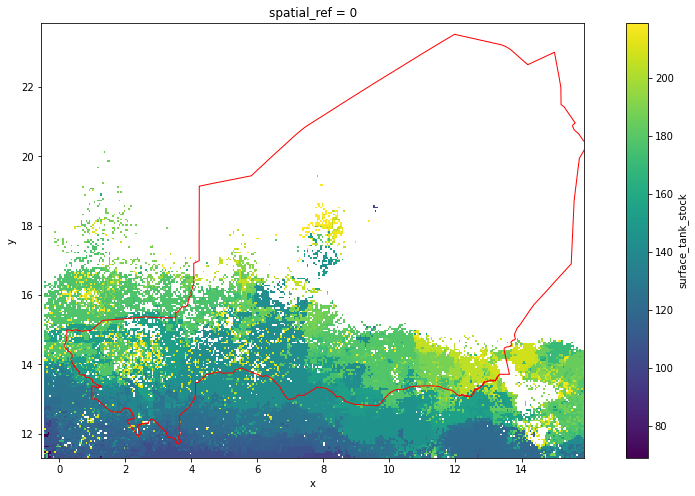

100%|██████████| 220/220 [01:42<00:00,  2.14it/s]


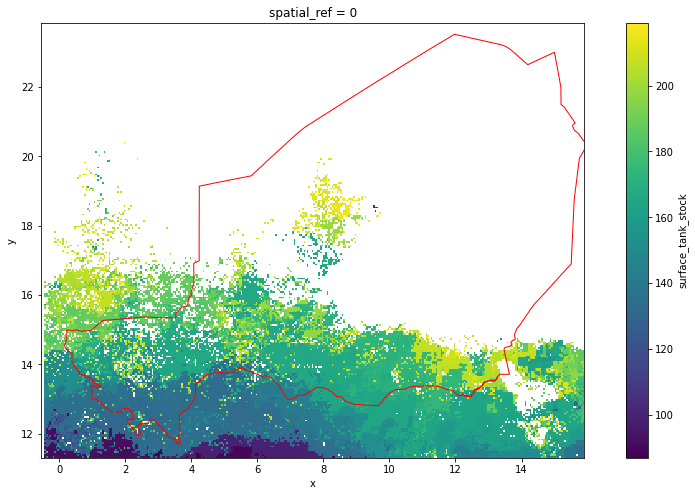

100%|██████████| 220/220 [01:35<00:00,  2.31it/s]


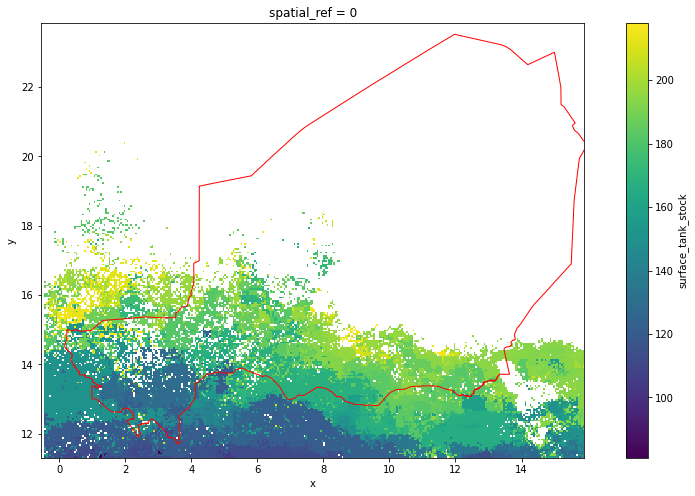

100%|██████████| 220/220 [01:46<00:00,  2.06it/s]


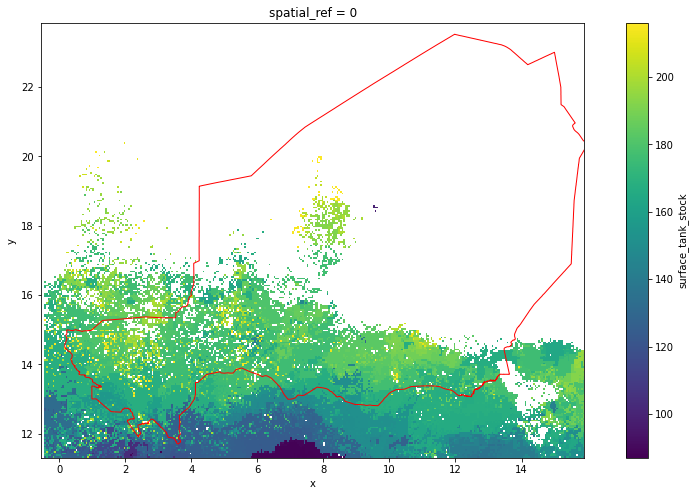

100%|██████████| 220/220 [02:09<00:00,  1.70it/s]


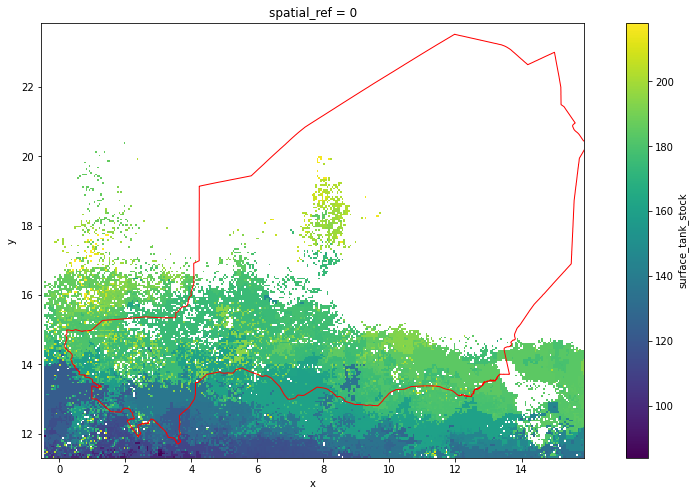

100%|██████████| 220/220 [01:37<00:00,  2.26it/s]


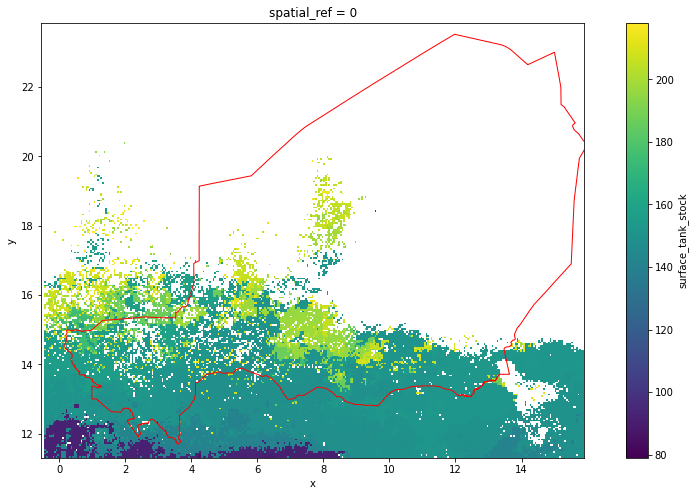

100%|██████████| 220/220 [01:31<00:00,  2.41it/s]


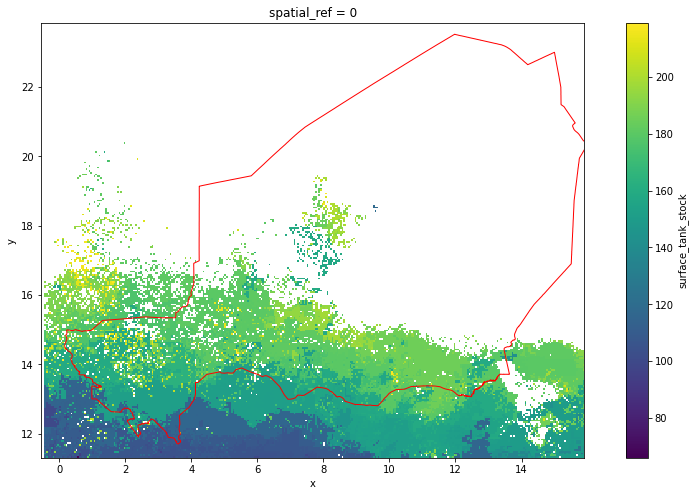

100%|██████████| 220/220 [02:14<00:00,  1.63it/s]


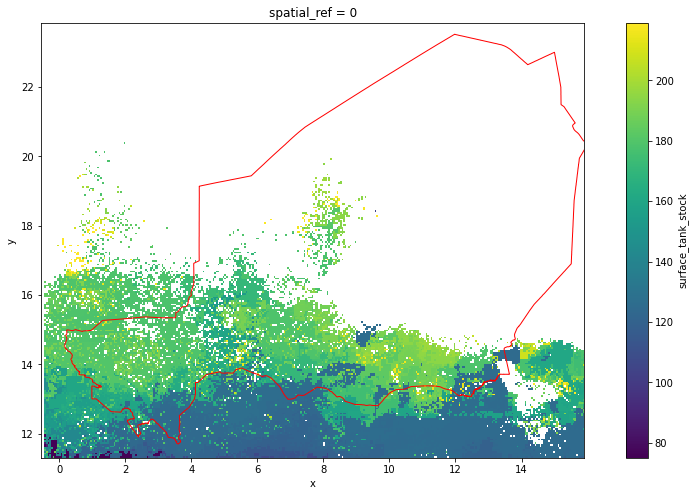

100%|██████████| 9/9 [26:38<00:00, 177.65s/it]


In [8]:
# as we want to study the variation of sowing date from one year to another, we perform one simulation per year
for year in tqdm(range(year_start,year_end+1)):

    # defining date of simulation start and simulation length in days
    date_start = datetime.date(year,1,1)

    # retrieving the grid size from the rainfall data (this method will be deprecated in the future)
    rainfall_data_path = rainfall_data_paths[dataset]
    grid_width, grid_height = get_grid_size(rainfall_data_path, date_start, duration)

    ## preparing the base dataset
    # initialize empty xarray dataset to load base data
    base_data = xr.Dataset()

    # load rainfall and weather data
    base_data = load_TAMSAT_data(base_data, rainfall_data_path, date_start, duration)
    base_data = load_AgERA5_data(base_data, climate_data_path, date_start, duration)

    # load soil data using the iSDA method (uses more recent maps)
    base_data = load_iSDA_soil_data_alternate(base_data, grid_width, grid_height)

    # compute the day length
    base_data = calc_day_length_raster_fast(base_data, date_start, duration)

    ## prepating simulation dataset
    # load variety, cropping system and soil parameters
    paramVariete, paramITK, paramTypeSol = load_YAML_parameters(file_paramVariete, file_paramITK, file_paramTypeSol)

    # creating simulation xarray dataset by copying the base data
    data = base_data.copy()

    # initializing all the necessary variables
    data = initialize_simulation(data, grid_width, grid_height, duration, paramVariete, paramITK, date_start)
    data = initialize_default_irrigation(data)
    data = calculate_once_daily_thermal_time(data, paramVariete)

    ## running the model
    data = run_waterbalance_model(paramVariete, paramITK, paramTypeSol, data, duration)

    ## detection of ESSD
    # creates a map of the first day at which the surface tank reaches the threshold
    # argmax returns the index of the first True value along the time axis, that is here the DOY as simulation started on Jan. 1st
    argmax = (data["surface_tank_stock"] > water_threshold).argmax(axis=0)
    result = xr.where(argmax==0, np.nan, argmax)

    # plotting the result map
    result.plot()
    gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
    plt.show()

    # saving xarray to geotiff
    result.rio.write_crs("EPSG:4326")
    result.rio.to_raster('./exemple_3_sowing_date_timeseries/'+dataset+'/'+str(year)+'.tif')

    # free memory
    del base_data, data

## Results : Hovmöller plot

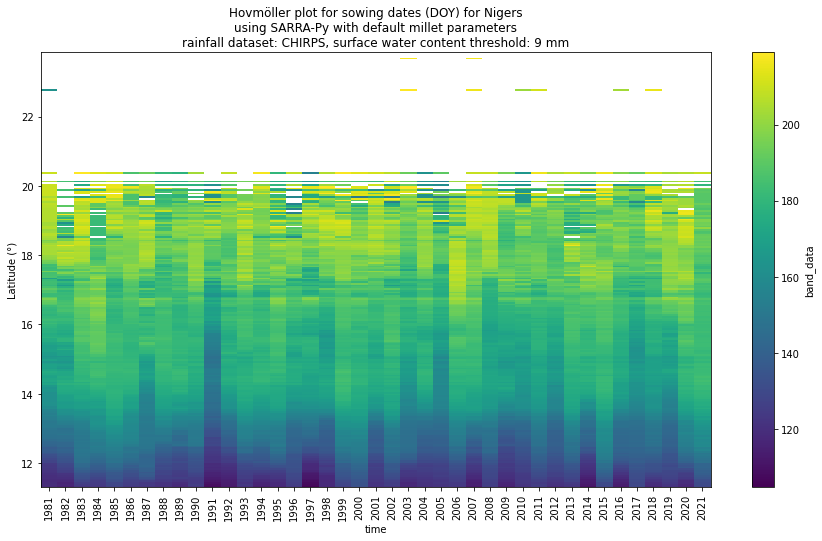

In [4]:
# listing the result files
path = "./exemple_3_sowing_date_timeseries/"+dataset+"/"
files = os.listdir(path)
files.sort()

# load all the files in a rioxarray along the time dimension and drop the band dimension
ds = xr.open_mfdataset(path + "*.tif", concat_dim="time", combine="nested")
ds = ds.squeeze("band")

# icrease plot size and make a hovmoller plot of ds["band_data"]
plt.rcParams["figure.figsize"] = (15, 8)
ds["band_data"].mean(axis=2).T.plot()
plt.xticks(range(len(files)), [file.strip('.tif') for file in files], rotation=90)
plt.title("Hovmöller plot for sowing dates (DOY) for Nigers\nusing SARRA-Py with default millet parameters\nrainfall dataset: "+dataset+", surface water content threshold: "+str(water_threshold)+" mm")
plt.ylabel("Latitude (°)")
plt.show()

# Results : average maps

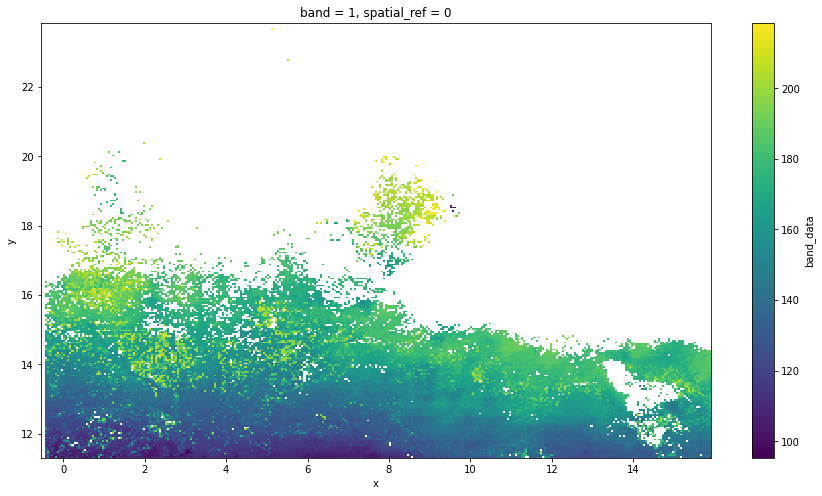

In [10]:
# listing the result files
path = "./exemple_3_sowing_date_timeseries/"+dataset+"/"
files = os.listdir(path)
files.sort()

# load all the files in a rioxarray along the time dimension and drop the band dimension
ds = xr.open_mfdataset(path + "*.tif", concat_dim="time", combine="nested")
ds = ds.squeeze("band")

# calculate average sowing date for each year
ds.mean(dim="time")["band_data"].plot()


/home/jeremy/.pyenv/versions/3.9.6/envs/venv_SARRA_Py/lib/python3.9/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


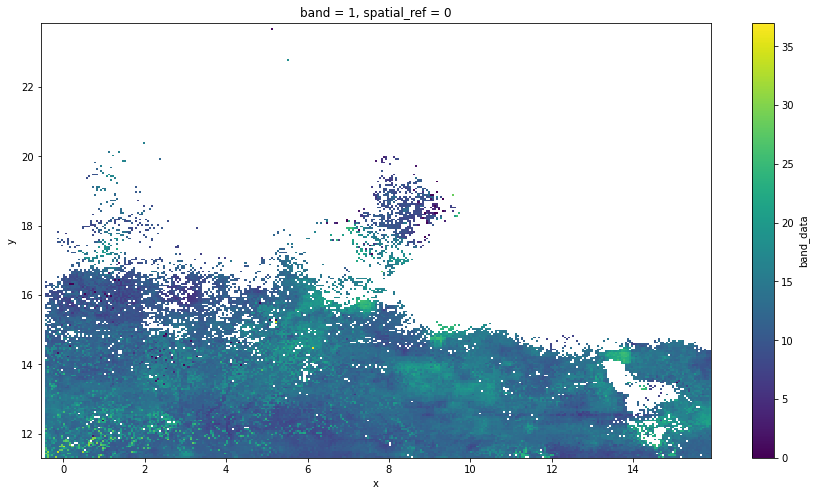

In [11]:
ds.std(dim="time")["band_data"].plot()

In [26]:
ds = ds.chunk({'time': -1})

/home/jeremy/.pyenv/versions/3.9.6/envs/venv_SARRA_Py/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


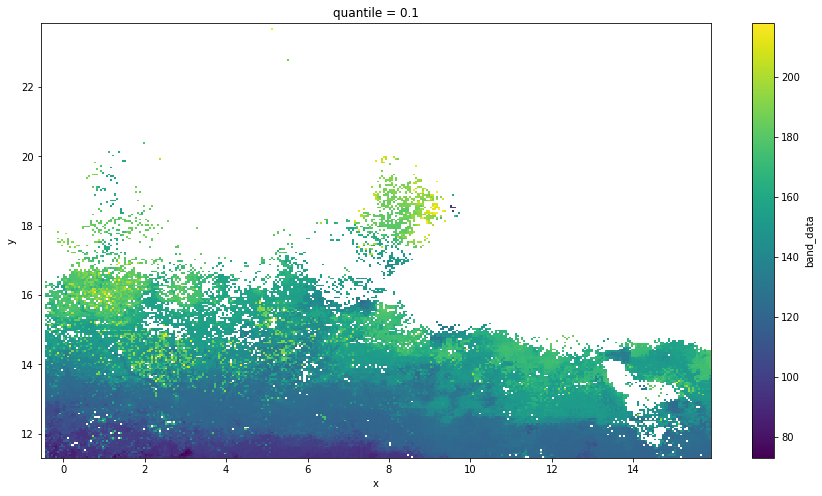

In [29]:
ds.quantile(0.1, dim="time")["band_data"].plot()

/home/jeremy/.pyenv/versions/3.9.6/envs/venv_SARRA_Py/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


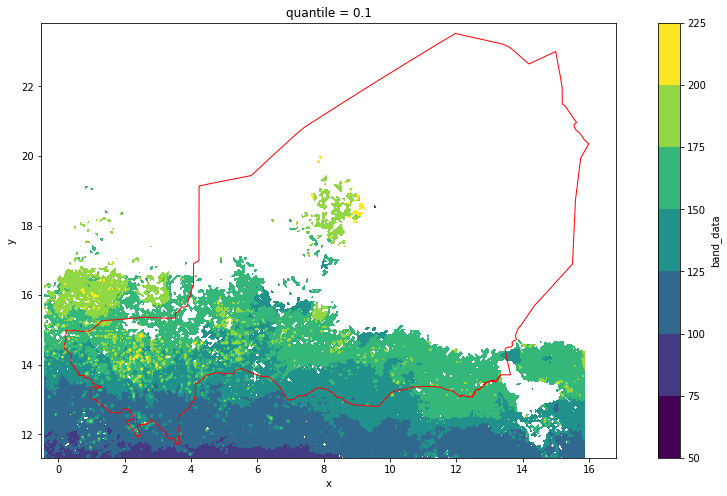

In [31]:
# make a contour map of the 10% quantile
ds.quantile(0.1, dim="time")["band_data"].plot.contourf()
gdf = gpd.read_file("https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_NER_shp.zip")
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=1.0)
plt.show()